In [1]:
import shapely
from shapely import Polygon

from osgeo import gdal
import rasterio

import atlite
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
from scipy.constants import physical_constants

In [22]:
weather_excel_path = "Parameters/weather_parameters.xlsx"

weather_parameters = pd.read_excel(weather_excel_path,
                                       index_col = 'Parameters'
                                       ).squeeze('columns')
weather_filename = weather_parameters['Filename']

hexagons = gpd.read_file('Resources/hex_transport.geojson')

cutout = atlite.Cutout('Cutouts_23/' + weather_filename +'.nc')
layout = cutout.uniform_layout()

In [23]:
location_hydro = gpd.read_file('Data/hydropower_dams.gpkg')
# location_hydro = gpd.read_file('Data/hydropower_dams_EU.gpkg')
# location_hydro = location_hydro[location_hydro["country_code"] != "NO"]
location_hydro.rename(columns={'Latitude': 'lat', 'Longitude': 'lon'}, inplace=True)
location_hydro.rename(columns={'head_example':'head'},inplace=True)
location_hydro.iloc[:3]

,SNo,Status,Fuel Type,lat,lon,Total capacity (MW),capacity,Expected Generation (GWh),total theoretical possible generation (local) GWh,COD,head,geometry
0,1,Existing,Reservoir,18.530336,102.547646,155.0,112.70,1025.0,1357.800,1971.0,45.5,POINT (102.54765 18.53034)
1,2,Existing,Run - Off,15.491752,106.278715,45.0,32.72,180.0,394.200,1991.0,10.0,POINT (106.27872 15.49175)
2,3,Existing,Reservoir,18.261088,104.562496,440.0,0.04,2691.0,0.438,2013.0,27.0,POINT (104.56250 18.26109)


In [24]:
hexagons['hydro'] = hexagons['hydro'].fillna(0)
hexagons['hydro'].unique()
# hex_final['capacity'] = hex_final['capacity'].fillna(0)

array([0.0000e+00, 4.3400e+00, 6.0730e+01, 8.6750e+01, 1.0410e+02,
       9.1100e+00, 2.6000e+00, 1.6660e+01, 5.9860e+01, 1.5182e+02,
       3.5569e+02, 1.3010e+01, 1.1278e+02, 1.5616e+02, 1.0800e+00,
       1.2150e+01, 1.4575e+02, 1.2580e+01, 5.7260e+01, 5.2050e+01,
       1.9950e+01, 2.7070e+01, 2.2556e+02, 1.0410e+01, 1.8218e+02,
       1.2666e+03, 4.7700e+00, 5.5520e+01, 6.9400e+00, 3.9040e+01,
       5.2100e+00, 6.1590e+01, 5.3353e+02, 8.7000e-01, 8.1900e+00,
       2.0821e+02, 4.3380e+01, 1.3187e+02, 9.3694e+02, 1.1408e+02,
       3.1230e+01, 7.6340e+01, 1.3881e+02, 1.4314e+02, 1.1451e+02,
       1.3000e+00, 2.6030e+01, 7.4610e+01, 1.4700e+00, 2.7760e+01,
       3.8170e+01, 1.3447e+02, 1.3534e+02, 2.1688e+02, 3.2530e+01,
       8.6800e+00, 4.1642e+02, 3.4700e+01, 5.6390e+02, 2.7800e+00,
       1.5620e+01])

In [ ]:
plant_basin_mapping = gpd.sjoin(location_hydro, laos_hydrobasins, how='left', predicate='intersects')
print(plant_basin_mapping.isnull().sum())  # Check for plants with no matching basin


In [38]:
# laos_hydrobasins = gpd.read_file('hydrobasins_lvl10/hybas_as_lev10_v1c.shp')
laos_hydrobasins = gpd.read_file('hybas_as_lev12_v1c\hybas_as_lev12_v1c.shp')
# laos_hydrobasins = gpd.read_file('hybas_eu_lev12_v1c\hybas_eu_lev12_v1c.shp')
# laos_hydrobasins = gpd.sjoin(laos_hydrobasins, location_hydro, how='left', predicate='intersects')

# laos_hydrobasins['lat'] = location_hydro.geometry.y
# laos_hydrobasins['lon'] = location_hydro.geometry.x
laos_hydrobasins.columns
# laos_hydrobasins.to_file('hydrobasins_lvl10/hybas_as_lev10_v1c.gpkg', driver='GPKG')

Index(['HYBAS_ID', 'NEXT_DOWN', 'NEXT_SINK', 'MAIN_BAS', 'DIST_SINK',
       'DIST_MAIN', 'SUB_AREA', 'UP_AREA', 'PFAF_ID', 'ENDO', 'COAST', 'ORDER',
       'SORT', 'geometry'],
      dtype='object')

In [40]:
print(location_hydro.is_valid.all())  # Should return True
laos_hydrobasins['geometry'] = laos_hydrobasins.buffer(0)
print(laos_hydrobasins.is_valid.all())  # Should return True


True
True


In [41]:
from shapely.geometry import Point

# Check if each plant intersects any basin
for plant in location_hydro.itertuples():
    point = plant.geometry
    intersecting_basins = laos_hydrobasins[laos_hydrobasins.geometry.intersects(point)]
    if intersecting_basins.empty:
        print(f"Plant at ({plant.lat}, {plant.lon}) does not intersect any basin.")


In [42]:
print("Plants (location_hydro) extent:", location_hydro.total_bounds)
print("Basins (laos_hydrobasins) extent:", laos_hydrobasins.total_bounds)


Plants (location_hydro) extent: [100.3861111  13.944063  107.361188   22.082521 ]
Basins (laos_hydrobasins) extent: [ 57.60833333   1.16666667 150.92148878  55.9375    ]


In [43]:
hydro_profile = cutout.hydro(
    plants=location_hydro,
    hydrobasins= laos_hydrobasins,
    per_unit=True                    # Normalize output per unit area
)

Determine upstream basins per plant: 0it [00:00, ?it/s]

Determine upstream basins per plant: 81it [00:02, 36.64it/s]
c:\Users\ls2823\AppData\Local\anaconda3\envs\geoh2_master\Lib\site-packages\scipy\sparse\_base.py:730: RuntimeWarning: divide by zero encountered in divide
  recip = np.true_divide(1., other)


[########################################] | 100% Completed | 16.64 s


Shift and aggregate runoff by plant: 81it [00:05, 14.85it/s]


In [44]:
hydro_profile

<xarray.DataArray (plant: 81, time: 8784)> Size: 6MB
array([[4796209.69770711, 4781608.20409363, 4750133.7760291 , ...,
        4808178.29462697, 4812359.53660297, 4814095.90842658],
       [ 398526.95293143,  390625.26082299,  394565.80600468, ...,
         387166.65105418,  380617.79741359,  377865.46001294],
       [8431134.71558781, 8531529.55229047, 8347144.01246858, ...,
        8786981.01686852, 8635294.75472685, 8589671.41134313],
       ...,
       [ 139912.29999186,  139193.58709103,  140333.22899819, ...,
         137084.85725505,  138165.76203629,  138165.76203629],
       [  35020.89569974,   34553.14688564,   35639.79445784, ...,
          50767.53429779,   48516.62043001,   50767.53429779],
       [  32537.17822724,   32482.22096594,   33145.32420698, ...,
          40388.92326016,   40388.92326016,   40388.92326016]])
Coordinates:
  * plant    (plant) int64 648B 0 1 2 3 4 5 6 7 8 ... 72 73 74 75 76 77 78 79 80
  * time     (time) datetime64[ns] 70kB 2023-01-01 ... 2024-01-01T23:00:00

In [54]:
def hydropower_potential(eta,flowrate,head):
    '''
    Calculate hydropower potential in Megawatts
    eta: Efficiency
    '''
    rho = 997 # kg/m3; Density of water
    g = physical_constants['standard acceleration of gravity'][0] # m/s2; Based on the CODATA constants 2018
    ###########################################################
    # Q = flowrate / 3600
    Q = (flowrate/(1000/24)) / 3600 # transform flowrate per h into flowrate per second
    return (eta * rho * g * Q * head) / (1000 * 1000) # MW


eta = 0.75 # Value for system efficiency of hydropower - source
def hydropower_potential_wrapper(flowrate, head):
    return hydropower_potential(eta, flowrate, head)

result = xr.apply_ufunc(
    hydropower_potential_wrapper,
    hydro_profile,
    xr.DataArray(location_hydro['head'], dims=['plant']),  # Ensure head values align with plant dimension
    vectorize=True
)

In [55]:

# Define the wrapper function to include capacity limiting and capacity factor calculation
def hydropower_potential_with_capacity(flowrate, head, capacity, eta):
    potential = hydropower_potential(flowrate, head, eta)
    limited_potential = xr.where(potential > capacity, capacity, potential)
    capacity_factor = limited_potential / capacity
    return capacity_factor

eta = 0.75 # efficiency of hydropower plant

capacity_factor = xr.apply_ufunc(
    hydropower_potential_with_capacity,
    hydro_profile,
    xr.DataArray(location_hydro['head'].values, dims=['plant']),
    xr.DataArray(location_hydro['capacity'].values, dims=['plant']),
    eta,
    vectorize=True,
    dask='parallelized',  # Dask for parallel computation
    output_dtypes=[float]
)

C:\Users\ls2823\AppData\Local\Temp\ipykernel_23832\3456052701.py:5: RuntimeWarning: invalid value encountered in divide
  capacity_factor = limited_potential / capacity


In [56]:

count_ones = (capacity_factor == 1).sum().item()
total_values = capacity_factor.size
percentage_ones = (count_ones / total_values) * 100

print(f"Total number of 1s: {count_ones}")
print(f"Percentage of 1s: {percentage_ones:.2f}%")

#v10 - 67.93%
#v12 - 67.70%

Total number of 1s: 188275
Percentage of 1s: 26.46%


In [57]:
capacity_factor

<xarray.DataArray (plant: 81, time: 8784)> Size: 6MB
array([[0.09466109, 0.0943729 , 0.0937517 , ..., 0.09489731, 0.09497983,
        0.0950141 ],
       [0.00595429, 0.00583624, 0.00589511, ..., 0.00578456, 0.00568672,
        0.0056456 ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [0.39352123, 0.39149976, 0.39470514, ..., 0.38556868, 0.38860887,
        0.38860887],
       [0.02398733, 0.02366695, 0.02441124, ..., 0.03477288, 0.03323113,
        0.03477288],
       [0.02316009, 0.02312097, 0.02359297, ..., 0.02874899, 0.02874899,
        0.02874899]])
Coordinates:
  * plant    (plant) int64 648B 0 1 2 3 4 5 6 7 8 ... 72 73 74 75 76 77 78 79 80
  * time     (time) datetime64[ns] 70kB 2023-01-01 ... 2024-01-01T23:00:00

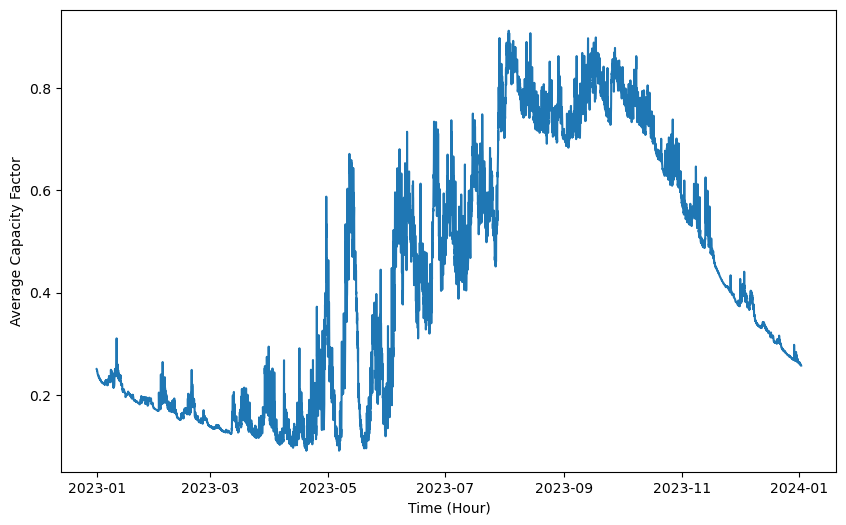

In [58]:
import matplotlib.pyplot as plt

# Calculate the average capacity factor for each hour across all plants
hourly_average = capacity_factor.mean(dim='plant')

# Plot the hourly average capacity factor over time
plt.figure(figsize=(10, 6))

# Plot the hourly average
plt.plot(hourly_average['time'], hourly_average.values)

# Add title and labels
# plt.title('Average Capacity Factor for Each Hour (All Plants)')
plt.xlabel('Time (Hour)')
plt.ylabel('Average Capacity Factor')

# Display the plot
plt.show()

# Optionally, save the plot
# plt.savefig("average_capacity_factor_per_hour.png")
